# Multi-Layer Perceptron Model Investigation


In [2]:
# Import required modules

import pandas as pd
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from category_encoders import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Pre-processing

In [3]:
# Read in Data
df = pd.read_csv('data/preprocessed_data.csv')
df.head()

print(f"size before dropping missing values: {df.shape}")
df.dropna(inplace=True) # drop rows with missing values
print(f"size after dropping missing values: {df.shape}")

size before dropping missing values: (800567, 8)
size after dropping missing values: (630784, 8)


### Feature Selection

In [4]:
X = df.drop(columns=['Label'])
Y = df['Label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
print(y_train.value_counts(normalize=True))


Label
1    0.810949
0    0.189051
Name: proportion, dtype: float64


### Data Splitting


In [7]:

# Select the categorical columns to encode
categorical_cols = ['BTicketType', 'TaskName', 'VMakeModel', 'VMake', 'VMid']

enc = TargetEncoder(cols = categorical_cols)
enc.fit(X_train, y_train)

# Transform both train and test sets
X_train_encoded = enc.transform(X_train)
X_test_encoded = enc.transform(X_test)




### Scaling

In [8]:
# Initialize the scaler
scaler = StandardScaler()

# Batch-wise partial fitting
batch_size = 1000
num_rows = X_train_encoded.shape[0]

for i in range(0, num_rows, batch_size):
    batch = X_train_encoded[i:i+batch_size]
    scaler.partial_fit(batch)

train_X_scaled = np.empty_like(X_train_encoded)

for i in range(0, num_rows, batch_size):
    batch = X_train_encoded[i:i+batch_size]
    train_X_scaled[i:i+batch_size] = scaler.transform(batch)

test_X_scaled = scaler.transform(X_test_encoded)



In [9]:
print(X_train_encoded.describe())


         BTicketType       TaskName     VMakeModel          VMake  \
count  504627.000000  504627.000000  504627.000000  504627.000000   
mean        0.810948       0.811122       0.810979       0.810944   
std         0.139611       0.086785       0.032585       0.017525   
min         0.000000       0.214239       0.568452       0.670940   
25%         0.802616       0.790667       0.797183       0.800993   
50%         0.802616       0.823783       0.809678       0.813697   
75%         0.845964       0.860199       0.825073       0.824627   
max         0.992192       0.992596       0.965122       0.914896   

               VYear           VMid  AdjustedPrice  
count  504627.000000  504627.000000  504627.000000  
mean     2018.918383       0.811084     438.002122  
std         2.891246       0.041062     634.491466  
min      1989.000000       0.461784   -7600.000000  
25%      2017.000000       0.791714      89.000000  
50%      2019.000000       0.809710     329.000000  
75%    

In [10]:
print(train_X_scaled.std(axis=0))  # Should not be all ~0

[1. 1. 1. 1. 1. 1. 1.]


In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier

# Apply SMOTE to the scaled training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_X_scaled, y_train)


## Training the Model

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, randint
from time import time
'''
# Define the model
mlp = MLPClassifier(max_iter=300, random_state=42)

# Define hyperparameter search space
params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 100), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': uniform(0.0001, 0.01),
    'batch_size': randint(16, 128),
}

# Time the random search
search_start = time()

random_search = RandomizedSearchCV(
    mlp,
    param_distributions=params,
    n_iter=3,
    scoring='accuracy',
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# Fit the random search
random_search.fit(train_X_scaled, train_Y)

search_end = time()
print(f"\n Randomized Search took: {search_end - search_start:.2f} seconds")'''


# Define model with your specific parameters
mlp = MLPClassifier(
    activation='relu',
    alpha=np.float64(0.006608884729488529),
    batch_size=68,
    hidden_layer_sizes=(100,),
    learning_rate_init=0.001 ,
    solver='sgd',
    max_iter=300,
    random_state=42,
    verbose=True,
    early_stopping=True, n_iter_no_change=10
)

# Train the model
train_start = time()
mlp.fit(X_train_resampled, y_train_resampled)
train_end = time()

print(f"\nTraining completed in {train_end - train_start:.2f} seconds.")

Iteration 1, loss = 0.58585937
Validation score: 0.664981
Iteration 2, loss = 0.57999729
Validation score: 0.664712
Iteration 3, loss = 0.57831466
Validation score: 0.665848
Iteration 4, loss = 0.57718222
Validation score: 0.666752
Iteration 5, loss = 0.57636844
Validation score: 0.666606
Iteration 6, loss = 0.57579776
Validation score: 0.667449
Iteration 7, loss = 0.57539789
Validation score: 0.668108
Iteration 8, loss = 0.57510290
Validation score: 0.667876
Iteration 9, loss = 0.57484557
Validation score: 0.668389
Iteration 10, loss = 0.57465783
Validation score: 0.668646
Iteration 11, loss = 0.57446433
Validation score: 0.668194
Iteration 12, loss = 0.57430889
Validation score: 0.668756
Iteration 13, loss = 0.57415509
Validation score: 0.669880
Iteration 14, loss = 0.57401823
Validation score: 0.669587
Iteration 15, loss = 0.57389769
Validation score: 0.669868
Iteration 16, loss = 0.57377981
Validation score: 0.669391
Iteration 17, loss = 0.57366320
Validation score: 0.669440
Iterat

## Evaluation

In [14]:
# 8. Evaluate
y_pred = mlp.predict(test_X_scaled)
y_proba = mlp.predict_proba(test_X_scaled)[:, 1]  # For ROC/AUC

print("Train score:", mlp.score(train_X_scaled, y_train))
print("Test score:", mlp.score(test_X_scaled, y_test)) 


Train score: 0.6952838433139725
Test score: 0.6887370498664362


In [ ]:
print(test_Y.shape)
print(y_pred.shape)


(15243,)
(15243,)


In [15]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , confusion_matrix, roc_auc_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6887370498664362
Precision: 0.8888971059507962
Recall: 0.7044699722580393
F1 Score: 0.7860101142209435
ROC AUC: 0.740913994098249
Confusion Matrix:
 [[14771  9014]
 [30254 72118]]


In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# Confidence score at the moment is its confidence in their prediction being correct
# Currently at 1 because its overfitting and is hence over confident 
def eval_classification_performance(model, train_X, y_train, eval_X, y_eval):
    """
    Evaluates a scikit-learn classification model on training and an evaluation dataset,
    displays confusion matrices, prints a classification report, and shows average confidence.

    Args:
        model: Trained scikit-learn classification model.
        train_X: Training features (pandas DataFrame).
        y_train: Training target (pandas Series).
        eval_X: Evaluation features (pandas DataFrame - typically validation or test).
        y_eval: Evaluation target (pandas Series - typically validation or test).
    """
    print("Evaluating model performance...")

    train_pred_labels = model.predict(train_X)

    eval_pred_labels = model.predict(eval_X)

    eval_pred_proba = model.predict_proba(eval_X)

    eval_confidence_in_prediction = np.max(eval_pred_proba, axis=1)

    train_acc = accuracy_score(y_train, train_pred_labels)
    eval_acc = accuracy_score(y_eval, eval_pred_labels) 

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Evaluation Accuracy: {eval_acc:.4f}") 

    print(f"Average Confidence in Predicted Class on Evaluation Set: {np.mean(eval_confidence_in_prediction):.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

    ConfusionMatrixDisplay.from_predictions(y_train, train_pred_labels, normalize='true', ax=axes[0])
    axes[0].set_title(f"Training Set Performance: Accuracy={train_acc:.2f}")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    ConfusionMatrixDisplay.from_predictions(y_eval, eval_pred_labels, normalize='true', ax=axes[1])
    axes[1].set_title(f"Evaluation Set Performance: Accuracy={eval_acc:.2f}") 
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")


    plt.tight_layout()
    plt.show()

    print("\nEvaluation Set Classification Report:") 
    
    print(classification_report(y_eval, eval_pred_labels))



Evaluating model performance...
Training Accuracy: 0.6748
Evaluation Accuracy: 0.6887
Average Confidence in Predicted Class on Evaluation Set: 0.6680


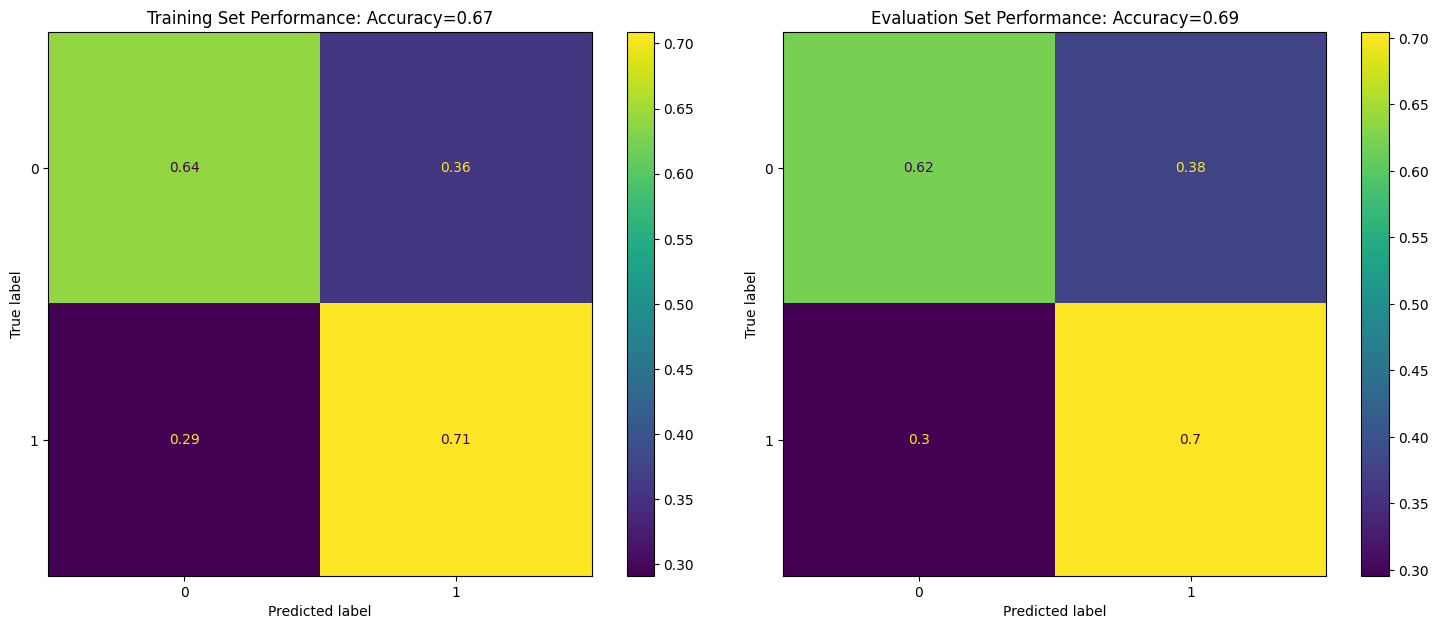


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.62      0.43     23785
           1       0.89      0.70      0.79    102372

    accuracy                           0.69    126157
   macro avg       0.61      0.66      0.61    126157
weighted avg       0.78      0.69      0.72    126157



In [20]:
eval_classification_performance(mlp, X_train_resampled, y_train_resampled, test_X_scaled, y_test)

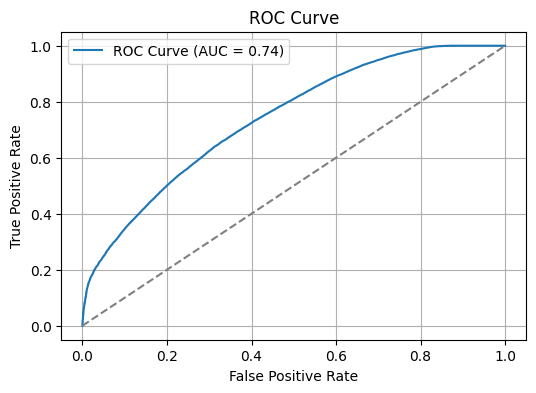

In [19]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

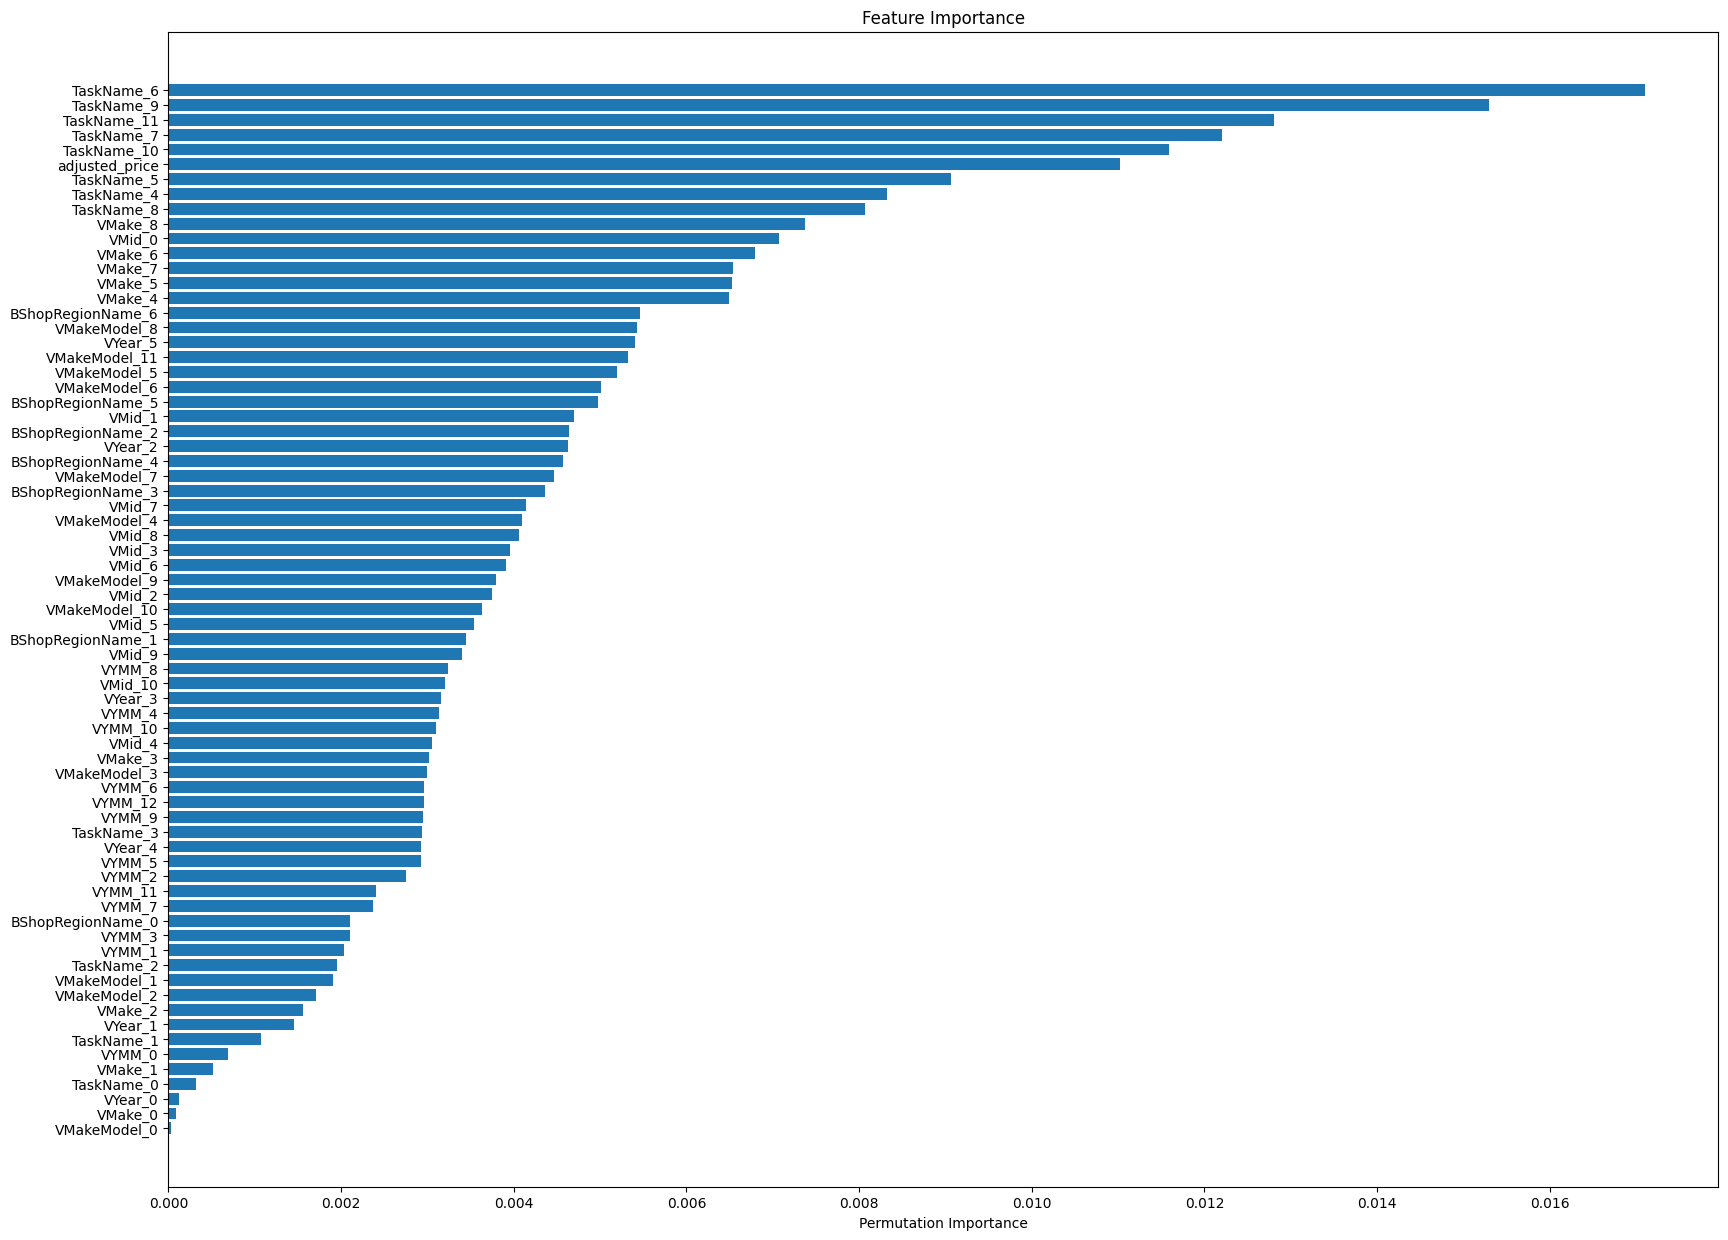

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_mlp, train_X_scaled, y_train, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(Encoded_train_X.columns)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_X_scaled,
    feature_names=Encoded_train_X.columns,
    class_names=np.unique(train_Y),
    mode='classification'
)

i = 0  # index of instance to explain
exp = explainer.explain_instance(train_X_scaled[i], best_mlp.predict_proba)


MemoryError: Unable to allocate 4.97 MiB for an array with shape (651617,) and data type int64

[('VMake_0 <= -0.03', -0.35069629350222065), ('VYMM_0 <= -0.09', -0.25436282688569245), ('adjusted_price > 0.15', -0.1534753738308017), ('VMakeModel_1 <= -0.10', 0.0730569284014029), ('TaskName_7 <= -0.74', -0.0703826102441674), ('VYMM_2 <= -0.36', -0.06618151923244339), ('VMake_4 <= -0.37', 0.06305412731089415), ('VMake_3 <= -0.18', -0.058417043184514836), ('TaskName_0 <= -0.04', 0.05332665874486834), ('VYear_0 <= -0.03', -0.045531854813953034)]


C:\Users\delac\AppData\Local\Temp\ipykernel_13728\482656293.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


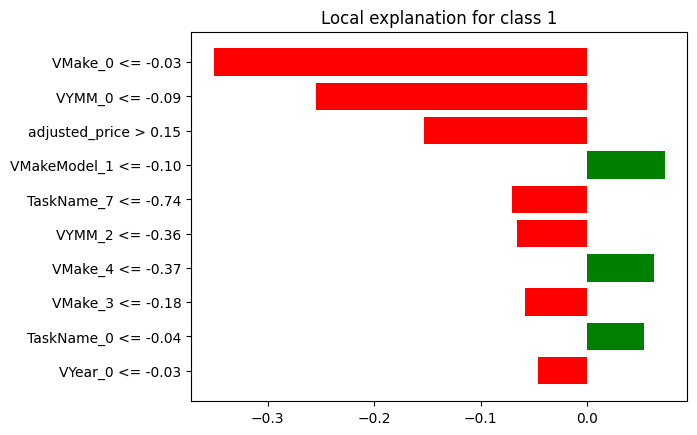

In [ ]:
print(exp.as_list())  # Outputs explanation as a list of (feature, weight) pairs
fig = exp.as_pyplot_figure()
fig.show()